# Supervised and unsupervised classification overview
Simple introduction on how classification may be useful for sentiment analysis

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Collect some data

In [2]:
import json

In [3]:
review_data_file = '../lexicon/data/yelp_sample.json'
with open(review_data_file, 'r') as infile:
    R = json.load(infile)

In [4]:
len(R)

10000

In [5]:
R[0]

{'content': "Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 'date': '2014-02-17',
 'stars': 4,
 'useful': 1,
 'funny': 0,
 'cool': 0,
 'business': 'Ue6-WhXvI-_1xUIuapl0zQ',
 'id': '----X0BIDP9tA49U3RvdSQ',
 'categories': ['American (Traditional)', 'Burgers', 'Restaurants']}

## Task: guess the number of stars for each review

In [6]:
target_values = set([doc['stars'] for doc in R])
target_values

{1, 2, 3, 4, 5}

## Indexing

In [7]:
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

In [8]:
def tokenize(document):
    return [x.lower() for x in word_tokenize(document) if x not in punctuation]

In [9]:
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform([x['content'] for x in R]).toarray() # dense to sparse
y = [x['stars'] for x in R]

In [10]:
features = vectorizer.get_feature_names_out()

In [11]:
features[:10]

array(["''", "'08", "'1921", "'20", "'60", "'90s", "'against", "'all",
       "'anti-sell", "'antica"], dtype=object)

In [12]:
X.shape

(10000, 34082)

## Unsupervised classification
We check to what extent clustering may help

In [13]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [14]:
ucls = Pipeline([('scaler', MinMaxScaler()), ('kmeans', KMeans(n_clusters=len(target_values)))])

In [15]:
y_pred = ucls.fit_predict(X, y)

In [16]:
print(y[:10])
print(y_pred[:10])

[4, 4, 5, 5, 5, 5, 4, 1, 5, 2]
[2 3 3 3 3 0 4 4 2 4]


### Show some statistics about clusters
Let's collect the real stars of documents per cluster

In [17]:
from collections import defaultdict

In [18]:
cluster_stars = defaultdict(list)
for i, k in enumerate(y_pred):
    cluster_stars[k].append(y[i])

In [19]:
import matplotlib.pyplot as plt

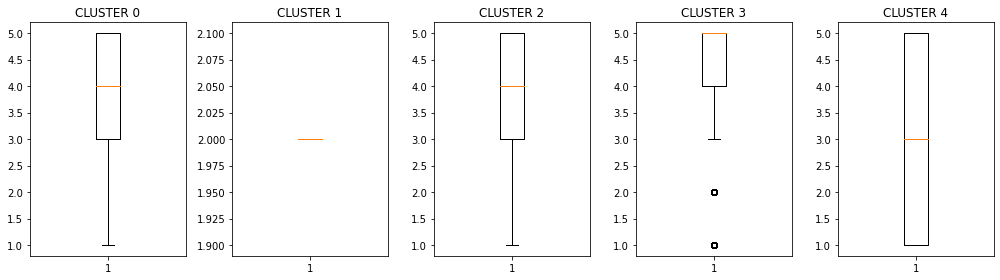

In [20]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=len(cluster_stars))
for k, stars in cluster_stars.items():
    ax[k].boxplot(stars)
    ax[k].set_title('CLUSTER {}'.format(k))
plt.tight_layout()
plt.show()

### Cluster evaluation

## Supervised classification

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
scls = Pipeline([('scaler', MinMaxScaler()), ('nb', MultinomialNB())])
scls.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('nb', MultinomialNB())])

In [41]:
y_pred = scls.predict(X_test)

In [42]:
y_pred[:10]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [44]:
P = scls.predict_proba(X_test)
P.shape

(2500, 5)

In [47]:
np.round(P[0], 3)

array([0.068, 0.   , 0.001, 0.226, 0.705])

In [48]:
P.mean(axis=0)

array([0.09330225, 0.00736453, 0.01222639, 0.16813631, 0.71897052])

### Evaluation

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.41      0.51       366
           2       1.00      0.01      0.01       196
           3       0.29      0.01      0.03       270
           4       0.44      0.17      0.25       612
           5       0.50      0.95      0.65      1056

    accuracy                           0.51      2500
   macro avg       0.58      0.31      0.29      2500
weighted avg       0.53      0.51      0.42      2500



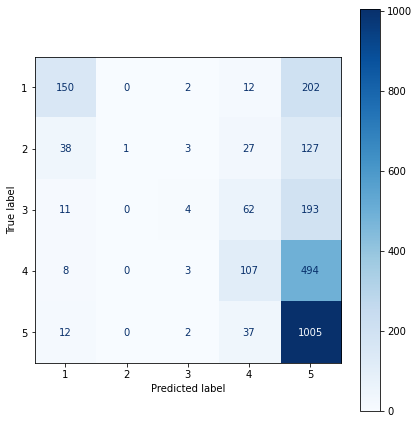

In [39]:
cm = confusion_matrix(y_test, y_pred, labels=list(range(1, 6)))
display = ConfusionMatrixDisplay(cm, display_labels=list(range(1, 6)))
fig, ax = plt.subplots(figsize=(6,6))
display.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()

# Task 2: what are the options to improve?